In [14]:
# unzip glove.6B.100d.txt
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: glove.6B.100d.txt       


In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
import re
from bs4 import BeautifulSoup

In [16]:
import os
import sys
import urllib
import gzip
from IPython.display import display, HTML

In [17]:
import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

In [20]:
def cleanString(review, stopWords):  #----- REVIEW ? -----#
  lemmatizer = WordNetLemmatizer()
  returnString = ""
  sentence_token = tokenize.sent_tokenize(review)
  idx_list = []
  for j in range(len(sentence_token)):
    single_sentence = tokenize.word_tokenize(sentence_token[j])
    sentences_filtered = [(idx, lemmatizer.lemmatize(w.lower())) for idx, w in enumerate(single_sentence) if w.lower() not in stopWords and w.isalnum()]
    idx_list.append([x[0] for x in sentences_filtered])
    word_list = [x[1] for x in sentences_filtered]
    returnString = returnString + ' '.join(word_list) + ' . '

  return returnString, idx_list


def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
  if training_split + validation_split + test_split != 1.0:
    raise ValueError("Split parameter sum should be equal to 1.0")

  total = len(dataframe.index)

  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
  train = train.sample(frac=1)
  temp_df = dataframe.drop(train.index)
  validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
  validation = validation.sample(frac=1)
  test = temp_df.drop(validation.index)
  test = test.sample(frac=1)
    
  print('Total: ', len(dataframe))
  print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
  print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
  print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

  return train, validation, test

def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

def to_categorical(series,class_dict):
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)

In [21]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

    #----- CODE FOR OVERRIDE -----#
    
    def get_config(self):
      config = super().get_config()
      config.update({
          'attention_dim' : self.attention_dim,
          'return_coefficients' : self.return_coefficients
      })
      return config

In [29]:
data_df=pd.read_csv('Fin.csv')
display(data_df)
data_df['Text']=data_df['Text'].apply(str)
result=data_df.dtypes
print(result)

,Text,Category
0,Florida raking in billions as Americans abando...,0
1,"Recently, changes to the U.S. tax code have en...",0
2,"MORE FROM FOXBUSINESS.COM... As it turns out, ...",0
3,"According to a new study from LendingTree, whi...",0
4,The Sunshine State drew in a net influx of abo...,1
...,...,...
22053,That's correct.,0
22054,Fining a company - which in effect just fines ...,0
22055,It was securing the bribe.,0
22056,Disrupting Democracy: When Big Tech Takes Over...,0


Text        object
Category     int64
dtype: object


In [30]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(data_df.shape[0]):
    sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  25
Average number of sentences in each document:  2


In [31]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

In [32]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

,Text,Category,Code
0,florida raking billion american abandon state ...,0,0
1,recently change tax code encouraged increasing...,0,0
2,turn however florida banking moving trend even...,0,0
3,according new study lendingtree analyzed irs d...,0,0
4,sunshine state drew net influx billion adjuste...,1,1


In [33]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

In [34]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

Found 400000 word vectors.
Total absent words are 2957 which is 11.88 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


In [35]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 0, 1: 1}
Total:  22058
Training:  17646 , Percentage:  0.7999818659896636
Validation:  2206 , Percentage:  0.10000906700516819
Test: 2206 , Percentage:  0.10000906700516819


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 50)]              0         
                                                                 
 word_embedding (Embedding)  (None, 50, 100)           2489900   
                                                                 
 word_gru (Bidirectional)    (None, 50, 100)           45600     
                                                                 
 word_dense (Dense)          (None, 50, 100)           10100     
                                                                 
 word_attention (AttentionLa  [(None, 100),            10200     
 yer)                         (None, 50, 1)]                     
                                                                 
Total params: 2,555,800
Trainable params: 65,900
Non-trainable params: 2,489,900
___________________________________________

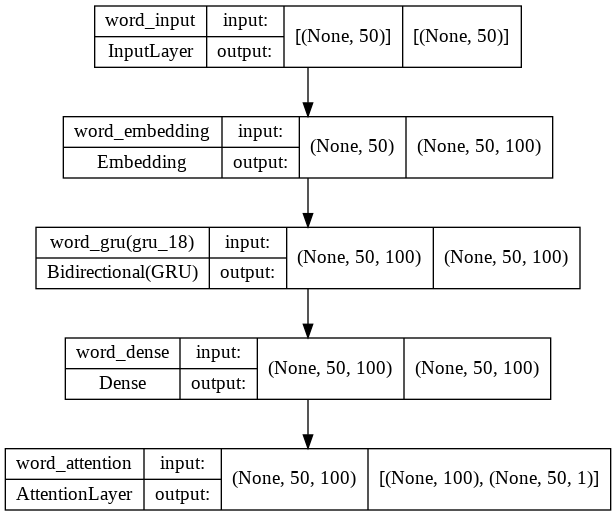

In [52]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(2, activation='sigmoid',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

Epoch 1/7
353/353 [==============================] - 376s 1s/step - loss: 0.2312 - acc: 0.9283 - val_loss: 0.1976 - val_acc: 0.9284
Epoch 2/7
353/353 [==============================] - 367s 1s/step - loss: 0.1684 - acc: 0.9338 - val_loss: 0.1565 - val_acc: 0.9374
Epoch 3/7
353/353 [==============================] - 371s 1s/step - loss: 0.1455 - acc: 0.9411 - val_loss: 0.1419 - val_acc: 0.9451
Epoch 4/7
353/353 [==============================] - 366s 1s/step - loss: 0.1300 - acc: 0.9466 - val_loss: 0.1494 - val_acc: 0.9383
Epoch 5/7
353/353 [==============================] - 371s 1s/step - loss: 0.1182 - acc: 0.9515 - val_loss: 0.1441 - val_acc: 0.9442
Epoch 6/7
353/353 [==============================] - 369s 1s/step - loss: 0.0996 - acc: 0.9569 - val_loss: 0.1485 - val_acc: 0.9461
Epoch 7/7
353/353 [==============================] - 368s 1s/step - loss: 0.0857 - acc: 0.9627 - val_loss: 0.1571 - val_acc: 0.9465
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


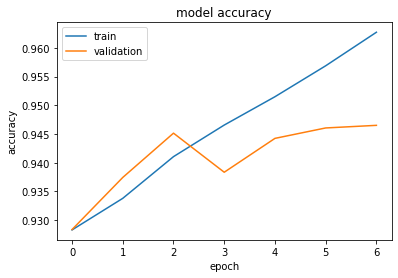

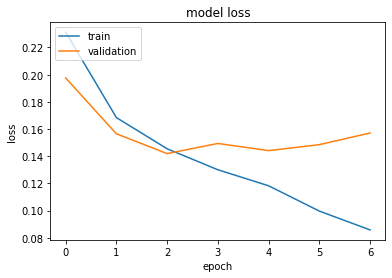

In [53]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [54]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

69/69 [==============================] - 17s 246ms/step - loss: 0.1656 - acc: 0.9406
Test set accuracy:  0.9406164884567261
Test set loss:  0.16560952365398407
